In [1]:
import os
import time
import h5py
import glob
import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from datetime import datetime

import scipy.stats as stats
from scipy.stats import linregress
from scipy.stats import weibull_min
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import curve_fit, minimize, fsolve
from scipy.optimize import differential_evolution

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

from playsound import playsound

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import wei_fit_update, fit_yearly_weibull_update, compute_beta, str_exp_fun, epl_fun, myfun_sse, down_wei, down_wei_beta_alpha, fast_corla_2d, myacf_2d
from ART_preprocessing import haversine, create_box, space_time_scales_agregations, wet_matrix_extrapolation, autocorrelation_neighborhood, area_lat_lon
from ART_plot import plot_neighborhood, plot_scales_aggregation, plot_wet_fraction_matrix, plot_autocorrelation, plot_scatter

import warnings
warnings.filterwarnings('ignore')

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
name, yy_s, yy_e, pixel = 'Coast Level', 2001, 2017, [45.00466666, 12.24819444]
# name, yy_s, yy_e, pixel  = 'Low Level', 2001, 2014, [45.42333333, 11.28941667]
# name, yy_s, yy_e, pixel = 'Medium Level', 2001, 2017, [46.01291666, 11.81291667]
# name, yy_s, yy_e, pixel = 'High Level', 2001, 2022, [46.19073266, 12.40789032]

maxmiss = 100

In [3]:
npix = 3 # each pixel is 10 km, with odd number the center is simetric (3, 5, 7 and 9)

thresh = 1 # default
# thresh = 2 
# thresh = 2.6 
# thresh = 3
# thresh = 4 
# thresh = 5 
# thresh = 6 
# thresh = 7
# thresh = 8

res = {} # Output dictionary with all information

In [4]:
reso = 0.5
buffer = 0.5*npix*reso # To define the limitis of box_3h

# L1 = 25
L0 = 10 #default 0.0001 = 0.1 meters

dt = 3 # time scale of the precipitation product [HOURS] (default 3 hours)

origin_x = 25 # linear spatial scale of origin gridded prcp [km] (default 25)
origin_t = 24 # time scale of origin gridded pecip [HOURS] (default 24 hours)

target_x = 10 # subgrid spatial scale we want pwet at [km](default 0.0001 km)
target_t = 24 # target time scale, in [HOURS] (default 24 hours)

cube1size = 5 # lateral size of cube used to decide among how many single pixel average at smallest scale
tmax = 48 # maximum time scale of integration [HOURS]

toll=0.005 # tolerence for optimization of downscaled correlation (default 0.005)

acf='mar' # acf='mar' for the power-law described in Marani 2003 (default), acf='str' for a stretched exponential 

In [5]:
CONDITION = 'OVERLEAP'; fig_val = 'OVERLAP'
# CONDITION = 'NONOVERLAP'; fig_val = 'NOVERLAP'
# CONDITION = 'FOCUS'; fig_val = 'FOCUS'
print(f'Using condition {CONDITION} for scales aggregation')

Using condition OVERLEAP for scales aggregation


In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load IMERG 3h data 05x05

In [7]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31_05x05.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 88MB
Dimensions:  (time: 49672, lon: 17, lat: 13)
Coordinates:
  * time     (time) datetime64[ns] 397kB 2001-01-01 ... 2017-12-31T21:00:00
  * lon      (lon) float32 68B 10.12 10.38 10.62 10.88 ... 13.62 13.88 14.12
  * lat      (lat) float32 52B 43.88 44.12 44.38 44.62 ... 46.38 46.62 46.88
Data variables:
    PRE      (time, lat, lon) float64 88MB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  IMERG 3 hour data for Veneto region
    history:      Tue Nov 12 09:42:36 2024: cdo remapbil,TRMM_Veneto_3h_1998_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

##  IMERG Daily accumulations

In [8]:
PRE_daily = DATA.resample(time ='D').sum(dim='time', skipna=False)
DATES_daily = PRE_daily['time']

## Load IMERG 3h data 01x01

In [9]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31.nc')

if os.path.exists(data_dir):
    DATA_01 = xr.open_dataset(data_dir)
    DATA_01 = DATA_01.sel(time=DATA_01.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

lats_01 = DATA_01['lat'].data
lons_01 = DATA_01['lon'].data

lon2d_01, lat2d_01 = np.meshgrid(lons_01, lats_01)

nlon_ref_01 = np.size(lons_01)
nlat_ref_01 = np.size(lats_01)

PRE_01 = DATA_01['PRE'].values
PRE_daily_01 = DATA_01.resample(time ='D').sum(dim='time', skipna=False)

print(PRE_01.shape)

del DATA_01

(49672, 30, 40)


## Search close pixel

In [10]:
distances = haversine(lat2d, lon2d, pixel[0], pixel[1])
min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
clat = lats[min_index[0]]
clon = lons[min_index[1]]

print('Close pixel for 0.5x0.5')
print()
print(f"Nearest IMERG lat: {clat}")
print(f'Station lat       : {pixel[0]}')
print()
print(f"Nearest IMERG lon: {clon}")
print(f'Station lon       : {pixel[1]}')

Close pixel for 0.5x0.5

Nearest IMERG lat: 45.125
Station lat       : 45.00466666

Nearest IMERG lon: 12.125
Station lon       : 12.24819444


In [11]:
distances_01 = haversine(lat2d_01, lon2d_01, pixel[0], pixel[1])
min_index_01 = np.unravel_index(np.argmin(distances_01, axis=None), distances_01.shape)
clat_01 = lats_01[min_index_01[0]]
clon_01 = lons_01[min_index_01[1]]

print('Close pixel for 0.1x0.1')
print()
print(f"Nearest IMERG lat: {clat_01}")
print(f'Station lat       : {pixel[0]}')
print()
print(f"Nearest IMERG lon: {clon_01}")
print(f'Station lon       : {pixel[1]}')

Close pixel for 0.1x0.1

Nearest IMERG lat: 45.04999923706055
Station lat       : 45.00466666

Nearest IMERG lon: 12.25
Station lon       : 12.24819444


## Compute L1

In [12]:
L1 = area_lat_lon(clat, clon, dy, dx)[0] # in Km
print(f'L1 scale: {L1}')

L1 scale: 23.375849166580615


## Compare products

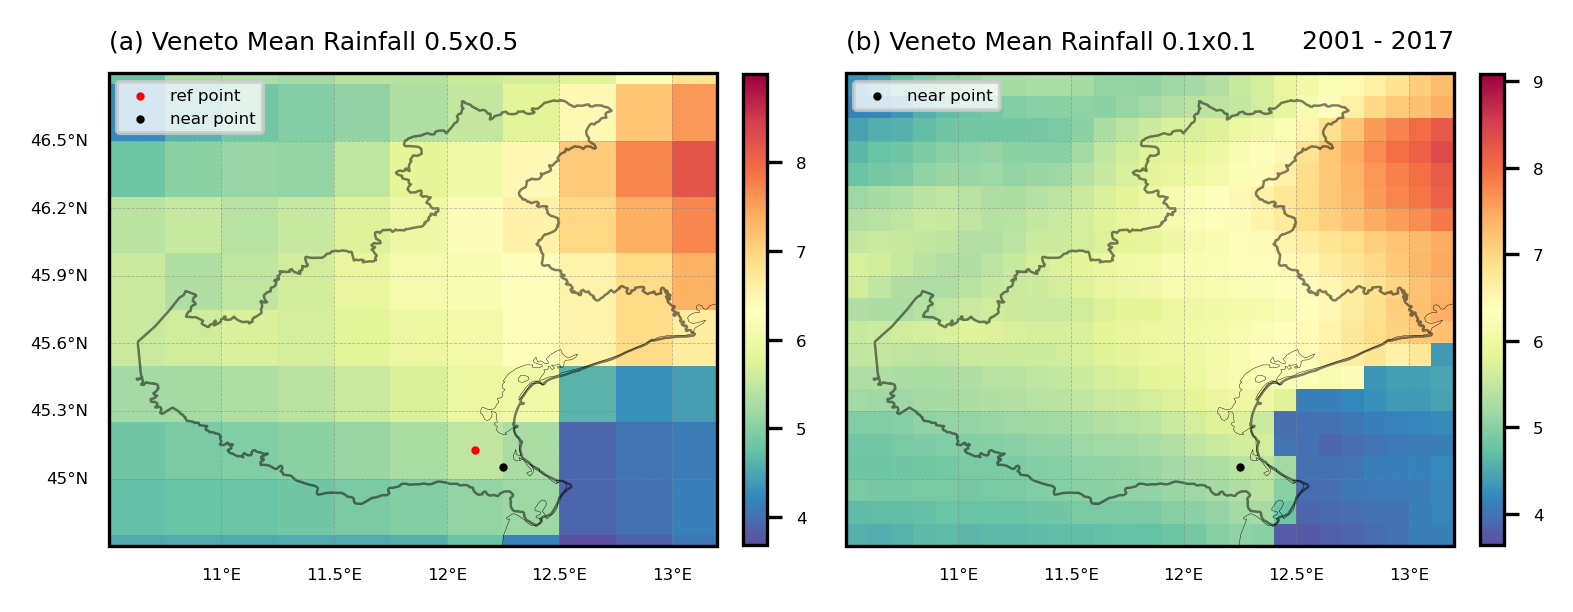

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(PRE_daily['PRE'],axis=0),cmap=cmap, label='mean')
ax1.scatter(clon, clat, 1, 'r', label='ref point')
ax1.scatter(clon_01, clat_01, 1, 'k', label='near point')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Veneto Mean Rainfall 0.5x0.5', loc='left', fontsize=6)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

ax1.set_extent([10.5, 13.2, 44.7, 46.8], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d_01, lat2d_01, np.nanmean(PRE_daily_01['PRE'],axis=0),cmap=cmap)
ax1.scatter(clon_01, clat_01, 1, 'k', label='near point')

plt.legend(fontsize=4, loc=2)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, pad=0.04, fraction=0.0358)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Veneto Mean Rainfall 0.1x0.1', loc='left', fontsize=6)
ax1.set_title(f'{yy_s} - {yy_e}', loc='right', fontsize=6)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.12)

In [14]:
IMERG_pixel_1dy = PRE_daily['PRE'][:,min_index[0],min_index[1]].data
IMERG_pixel_xr = xr.DataArray(IMERG_pixel_1dy,  coords={'time':PRE_daily['time'].values}, dims=('time'))

In [15]:
IMERG_pixel_1dy_01 = PRE_daily_01['PRE'][:,min_index_01[0],min_index_01[1]].data
IMERG_pixel_xr_01 = xr.DataArray(IMERG_pixel_1dy_01,  coords={'time':PRE_daily['time'].values}, dims=('time'))

In [16]:
print(f'IMERG PIXEL SHAPE: {IMERG_pixel_1dy.shape}')
print(f'RAIN GAUGE SHAPE : {IMERG_pixel_1dy_01.shape}')

IMERG PIXEL SHAPE: (6209,)
RAIN GAUGE SHAPE : (6209,)


## Weibull Parameters

In [17]:
print(f'IMERG threshold: {thresh} mm')
OBS_WEIBULL_YEAR = fit_yearly_weibull_update(IMERG_pixel_xr_01, thresh=thresh, maxmiss=maxmiss)
IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(IMERG_pixel_xr, thresh=thresh, maxmiss=maxmiss)

IMERG threshold: 1 mm


Export as: ../fig/Rainfall_OBS_IMERG_weibull.png


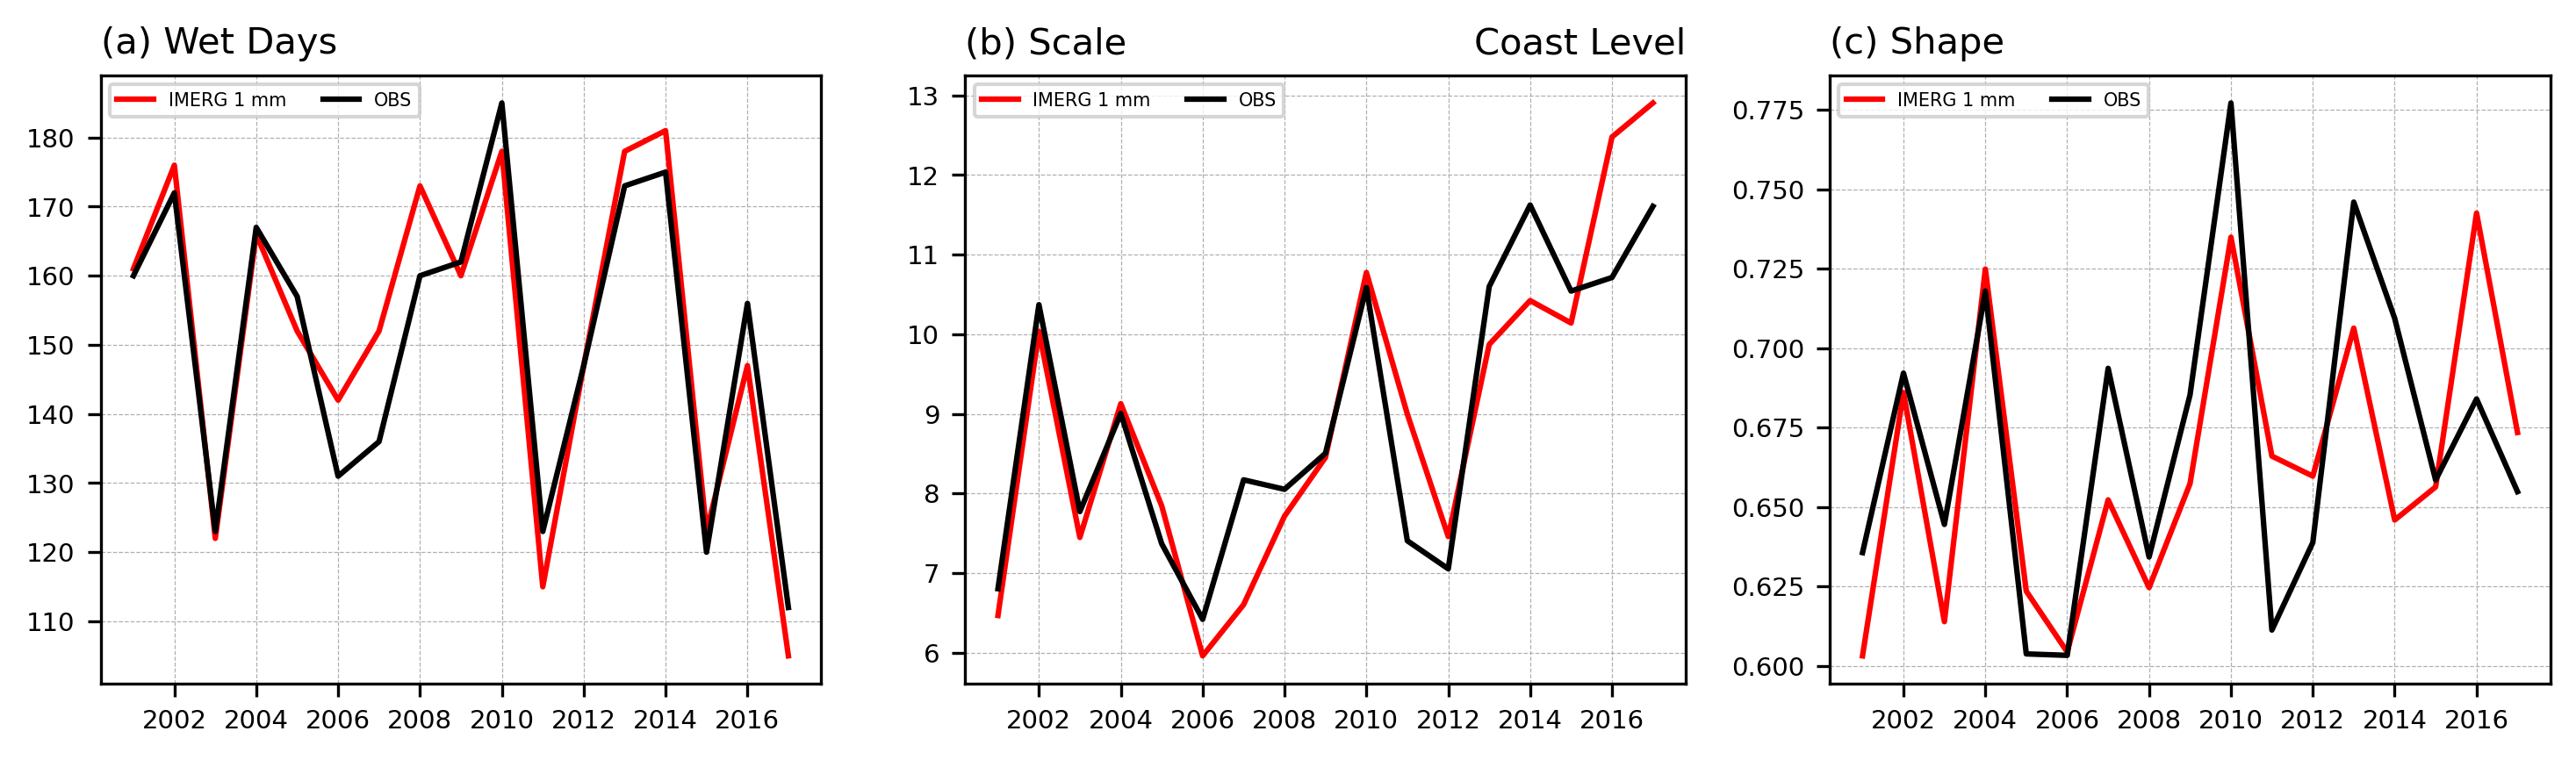

In [18]:
fig = plt.figure(figsize=(12,3),dpi=300)
gs = gridspec.GridSpec(1,3)

ax1 = plt.subplot(gs[0,0])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,0], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,0], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(a) Wet Days', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(20,160)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,1], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,1], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(b) Scale', loc='left', fontsize=10)
ax1.set_title(f'{name}',loc='right',fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(5,25)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,2], c='r', label='IMERG 1 mm')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,2], c='k', label='OBS')
ax1.legend(fontsize=5, ncol=3)
ax1.set_title('(c) Shape', loc='left', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
# ax1.set_ylim(0.5,1.3)
ax1.grid(linewidth=0.3, linestyle='--')

image_dir = f'../fig/Rainfall_OBS_IMERG_weibull.png'
print(f'Export as: {image_dir}')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [19]:
box_3h, bcond = create_box(DATA, clat, clon, npix, 0.3)
print(f'Dimension of box3d: {box_3h.shape}')

Dimension of box3d: (3, 3, 49672)


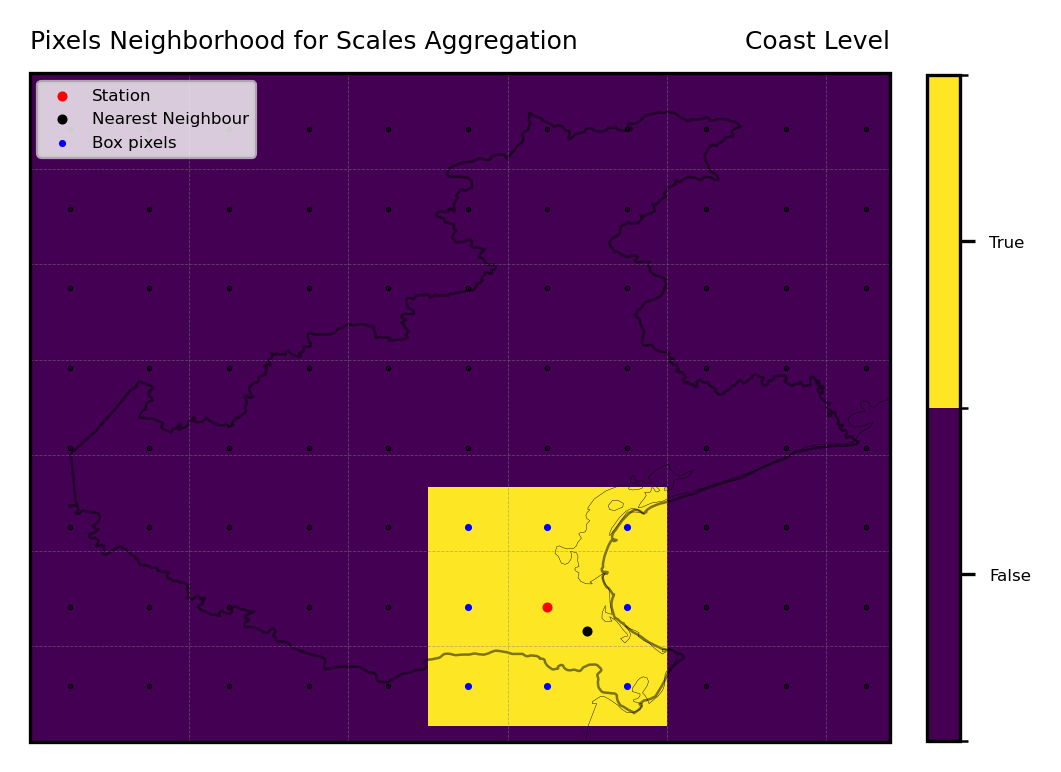

In [20]:
# Station_pos = CL_INFO['Lat'], CL_INFO['Lon'] 
close_pixel = clat, clon
image_out = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_scale.png'

plot_neighborhood(box_3h, lon2d, lat2d, bcond, [clat, clon], [clat_01, clon_01], name, image_out, save=False)

In [21]:
smax = box_3h.shape[0] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*dt
tscales = tscales[tscales < tmax + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*L1
ntscales = np.size(tscales)
nsscales = np.size(xscales)

print(f'Maximum Spatial Scale: {smax*L1} km')
print(f'Number of Spatial Scale: {nsscales}')
print()
print(f'Maximum time Scale   : {tmax} h')
print(f'Number of Time Scale: {ntscales}')

Maximum Spatial Scale: 70.12754749974184 km
Number of Spatial Scale: 3

Maximum time Scale   : 48 h
Number of Time Scale: 10


## Wet Fraction

In [22]:
WET_MATRIX = space_time_scales_agregations(box_3h, L1, CONDITION, tscales, xscales, npix, thresh)

Using condition: OVERLEAP

Agregation for time scale: 3 hours
Mean wet fraction for scale: 23.375849166580615 km
Mean wet fraction for scale: 46.75169833316123 km
Mean wet fraction for scale: 70.12754749974184 km

Agregation for time scale: 6 hours
Mean wet fraction for scale: 23.375849166580615 km
Mean wet fraction for scale: 46.75169833316123 km
Mean wet fraction for scale: 70.12754749974184 km

Agregation for time scale: 9 hours
Mean wet fraction for scale: 23.375849166580615 km
Mean wet fraction for scale: 46.75169833316123 km
Mean wet fraction for scale: 70.12754749974184 km

Agregation for time scale: 12 hours
Mean wet fraction for scale: 23.375849166580615 km
Mean wet fraction for scale: 46.75169833316123 km
Mean wet fraction for scale: 70.12754749974184 km

Agregation for time scale: 15 hours
Mean wet fraction for scale: 23.375849166580615 km
Mean wet fraction for scale: 46.75169833316123 km
Mean wet fraction for scale: 70.12754749974184 km

Agregation for time scale: 18 hours


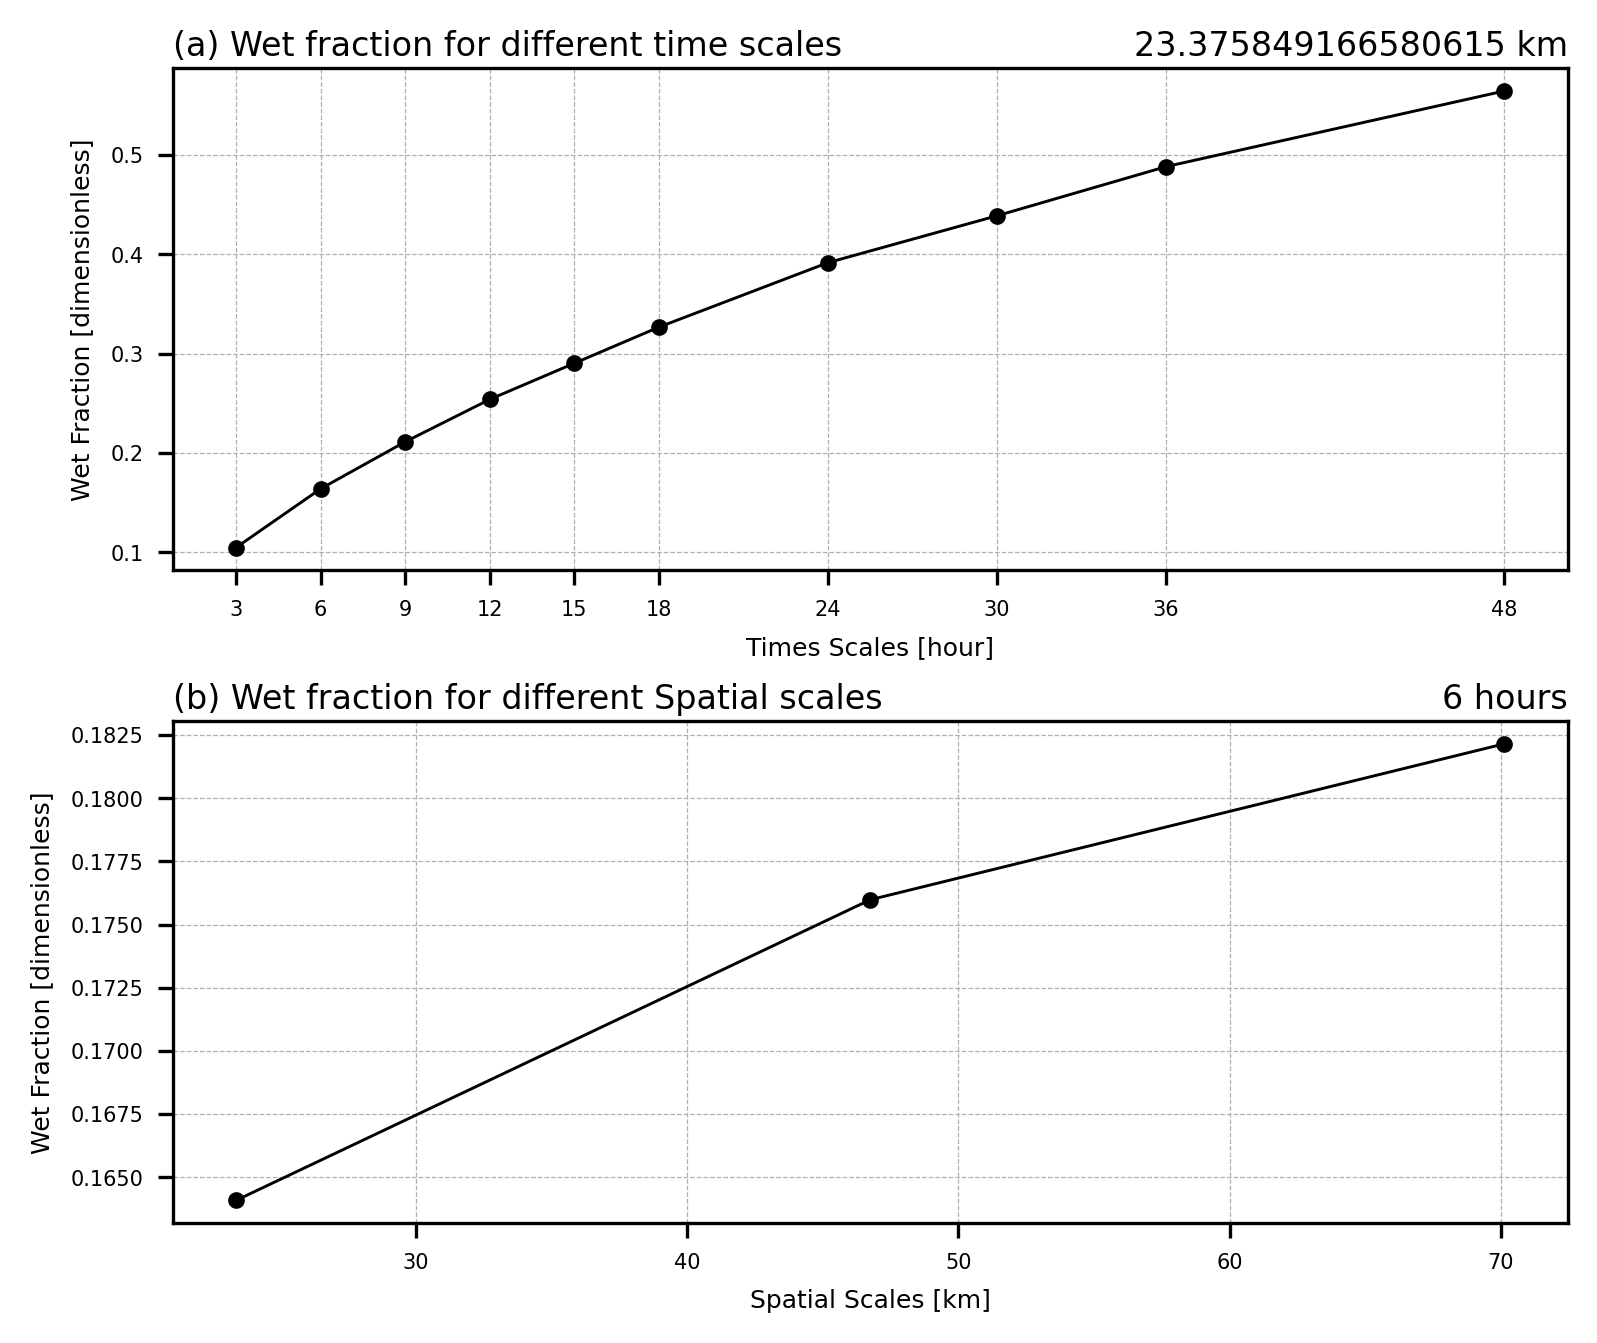

In [23]:
image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_aggregation.png'
plot_scales_aggregation(WET_MATRIX, xscales_km, tscales, 0, 1, image_dir, save=False)

## Wet Matrix Interpolation

In [24]:
ninterp = 2000 # number of interpolation in time dimension

xscales_km_2d, tscales_2d = np.meshgrid(xscales_km, tscales)

ntscales = np.size(tscales)
nxscales = np.size(xscales)

tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), ninterp) # 2000 values between min y max de time scale
WET_MATRIX_INTER = np.zeros((ninterp, nxscales)) # 2000, 5

for col in range(nxscales):
    WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col]) # Interpolated wet fraction matrix

## Wet Matrix Extrapolation

In [25]:
WET_MATRIX_EXTRA, new_spatial_scale = wet_matrix_extrapolation(WET_MATRIX_INTER, xscales_km, tscales_INTER, L1, npix)

## Compute Beta

In [26]:
origin_ref = [origin_x, origin_t]
target_ref = [target_x, target_t]

In [27]:
beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)
print(f'beta: {beta}')

beta: 1.091375417173489


## Plot Wet Fraction Matrix

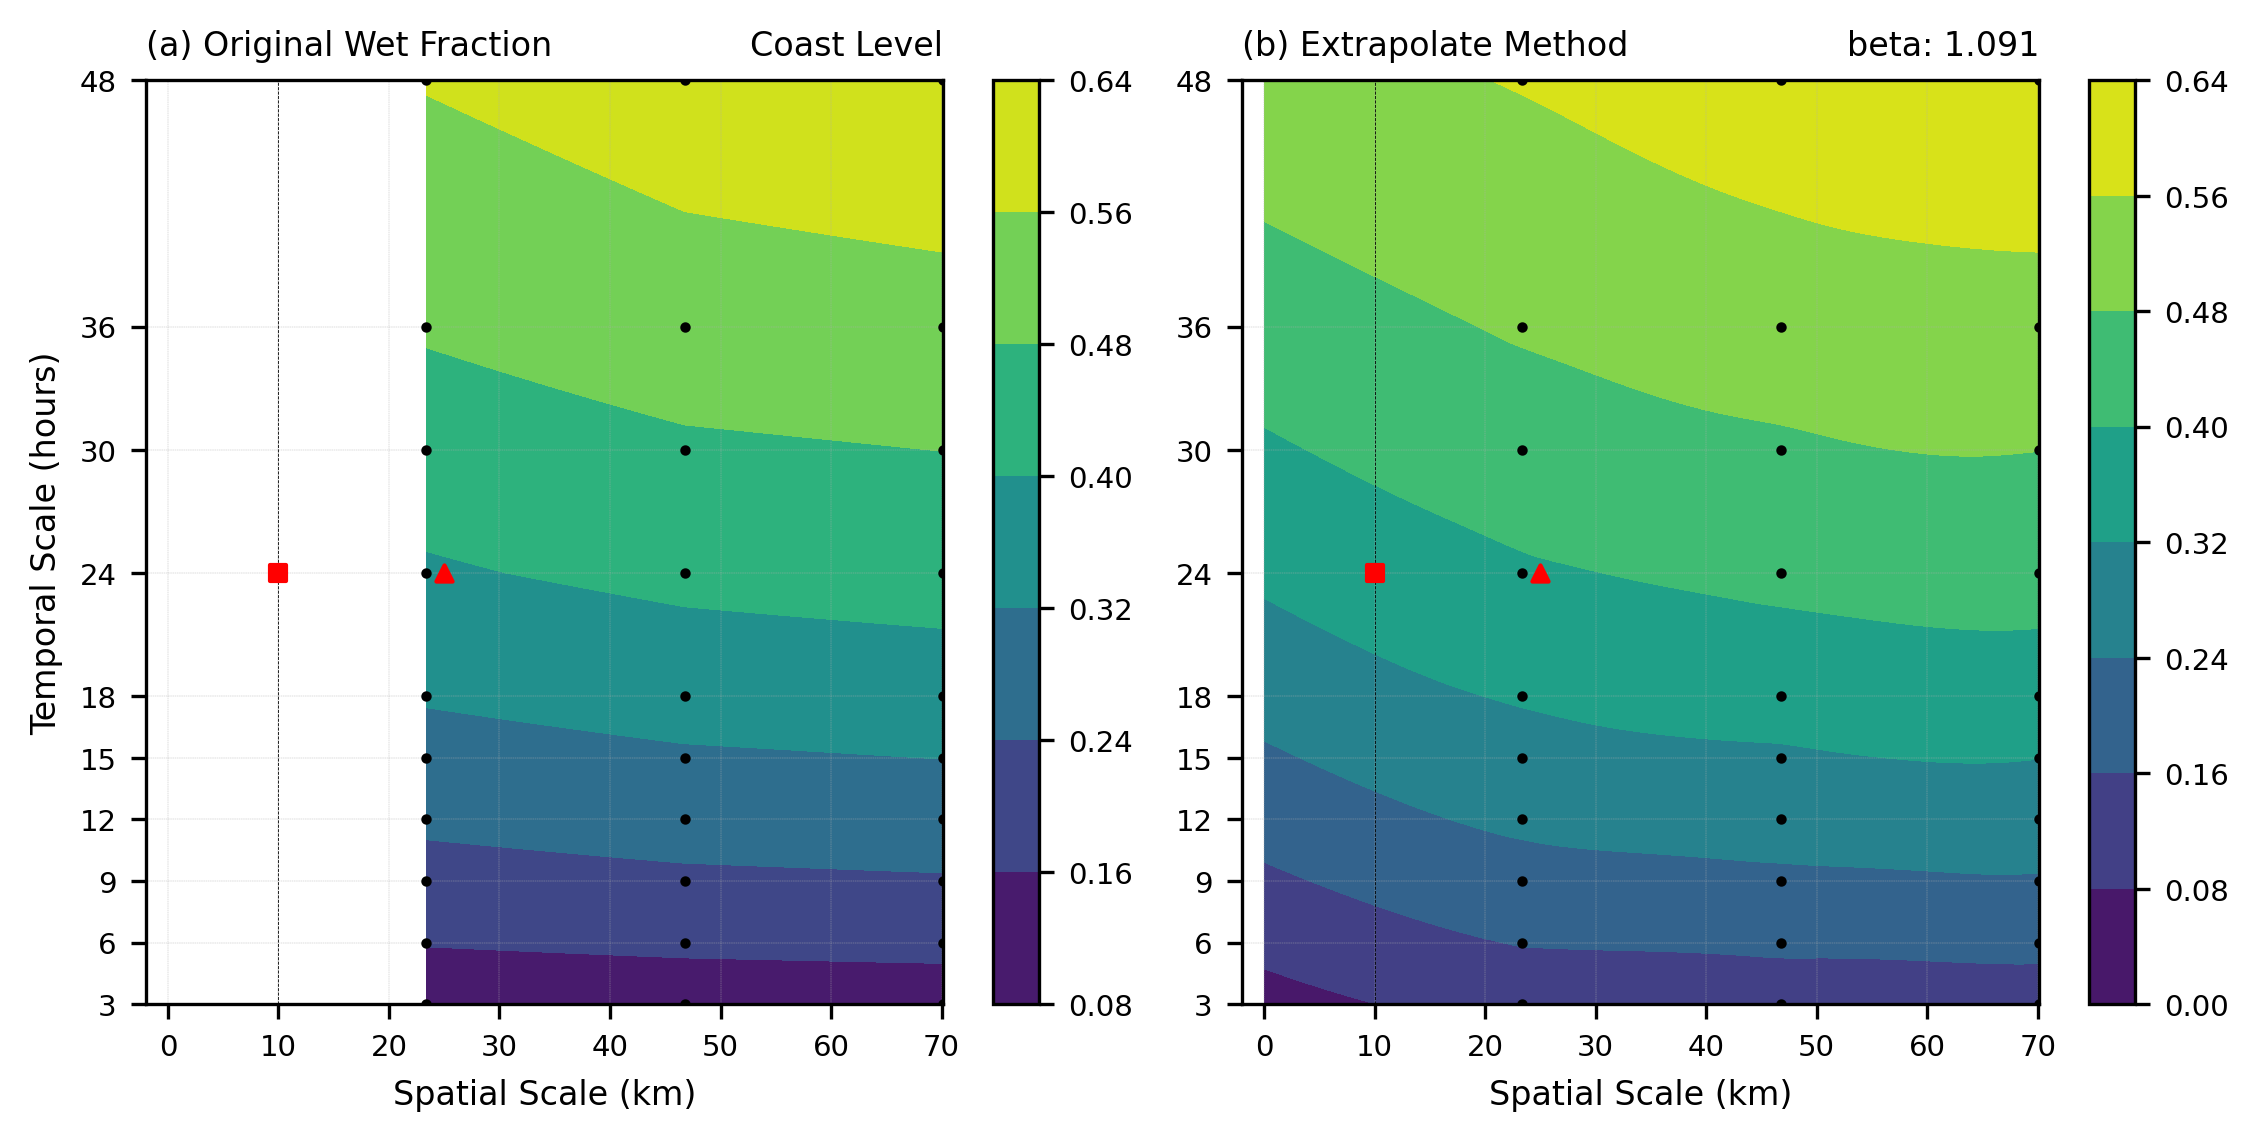

In [28]:
image_dir = f'../fig/Veneto_IMERG_{name.replace(' ','_')}_{yy_s}_{yy_e}_WF_{fig_val}.png'
plot_wet_fraction_matrix(
                WET_MATRIX_INTER, 
                xscales_km, tscales, tscales_INTER, 
                WET_MATRIX_EXTRA, 
                new_spatial_scale, 
                origin_ref, target_ref, 
                name, image_dir, save=False)

## Autocorrelation Neighborhood and fit

In [29]:
vdist, vcorr, distance_vector = autocorrelation_neighborhood(box_3h, cor_method = 'spearman')
FIT, _ = curve_fit(str_exp_fun, vdist, vcorr)
FIT_d0, FIT_mu0 = FIT
FIT, _ = curve_fit(epl_fun, vdist, vcorr)
FIT_eps, FIT_alp = FIT

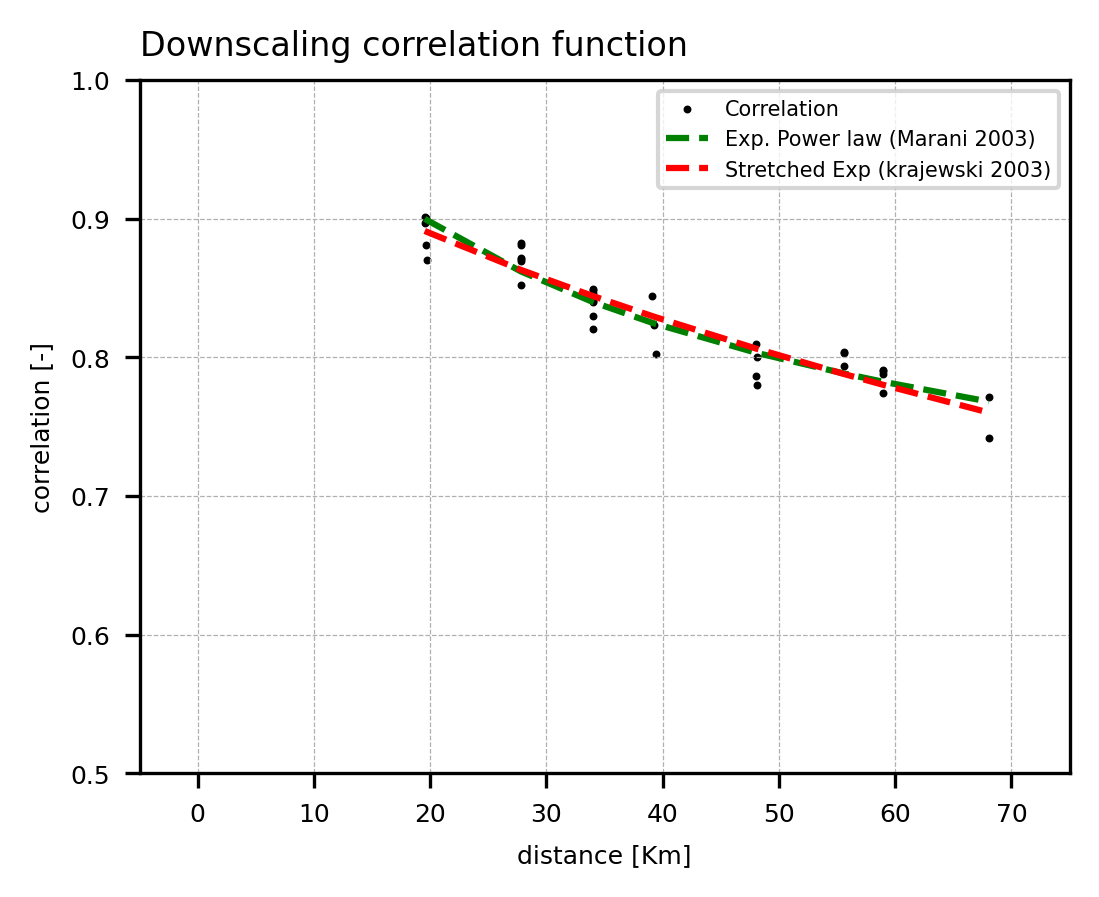

In [30]:
nameout = f'../fig/Corr_function_Marani_Krajewski.png'
plot_autocorrelation(vdist, vcorr, FIT_eps, FIT_alp, FIT_d0, FIT_mu0, nameout, save=False)

In [31]:
vdist_sorted = np.sort(vdist) # order distance
vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
toll_cluster = 1

cluster = np.zeros(len(vdist_sorted))
count = 0
for i in range(1, len(vdist_sorted)):
    if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
        cluster[i] = count
    else:
        count = count + 1
        cluster[i] = count

clust = set(cluster) # Extract only the uniques values
nclust = len(clust) # Numero de grupos
print(f'Number of clusters: {nclust}')

vdist_ave = np.zeros(nclust)
vcorr_ave = np.zeros(nclust)
for ei, elem in enumerate(clust):
    di = vdist_sorted[cluster==elem] # Distance
    ci = vcorr_sorted[cluster==elem] # Correlation
    vdist_ave[ei] = np.mean(di) # Mean Distance
    vcorr_ave[ei] = np.mean(ci) # Mean Correlation

Number of clusters: 8


In [32]:
FIT, _ = curve_fit(epl_fun, vdist_ave, vcorr_ave)
FIT_ave_eps, FIT_ave_alp = FIT

Text(0, 0.5, 'Spearman Correlation')

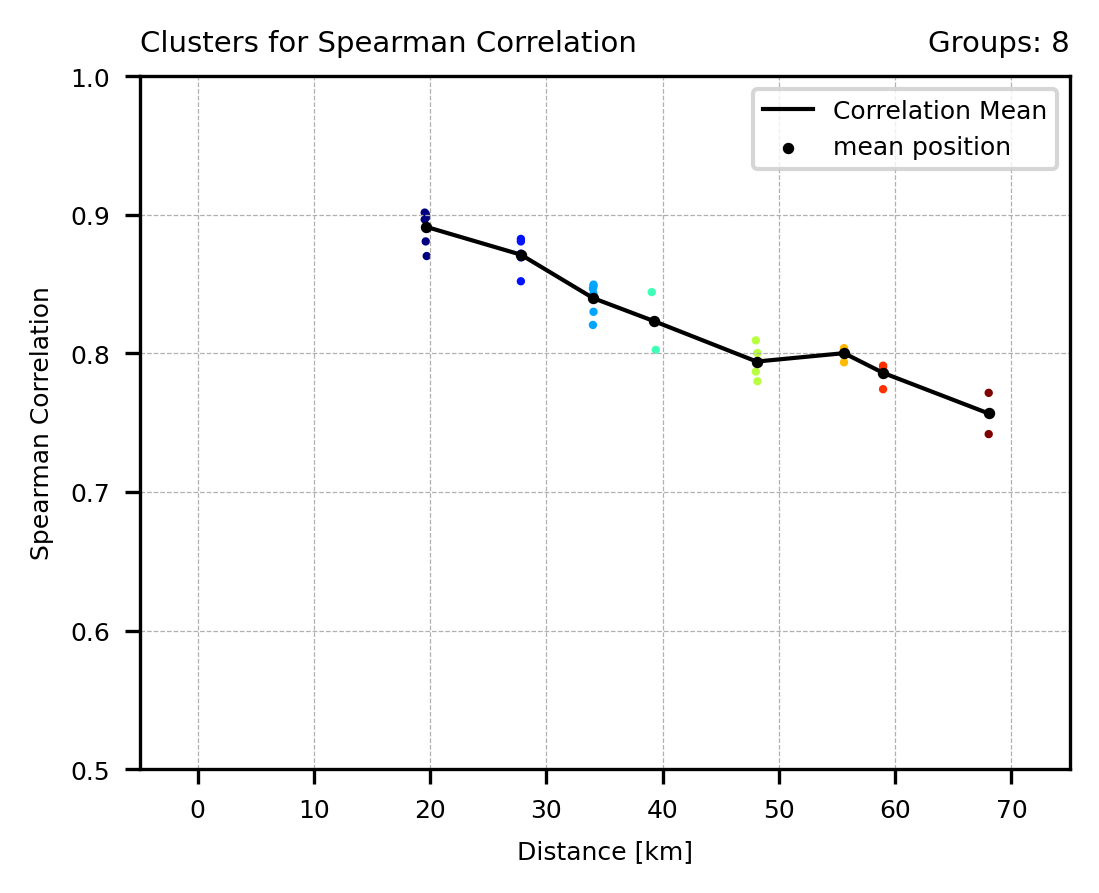

In [33]:
fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(vdist_sorted, vcorr_sorted, s=1, c=cluster, cmap='jet') # Sorted for cluste has same color
ax1.plot(vdist_ave, vcorr_ave, '-k', linewidth=1, label='Correlation Mean')
ax1.scatter(vdist_ave, vcorr_ave, s=3, c='k', label='mean position', zorder=5)

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 6)

ax1.xaxis.set_tick_params(labelsize=6)
ax1.yaxis.set_tick_params(labelsize=6)

ax1.set_xlim([-5, min(100, 10*(np.round(np.max(vdist))//10+1.5))])
ax1.set_ylim([0.5, 1.0])

ax1.set_title('Clusters for Spearman Correlation', loc='left', fontsize=7)
ax1.set_title(f'Groups: {nclust}', loc='right', fontsize=7)
ax1.set_xlabel('Distance [km]', fontsize=6)
ax1.set_ylabel('Spearman Correlation', fontsize=6)

## Compute Alpha

In [34]:
bounds = [(0.0, 100.0),(0, 1)]
def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, L1, acf=acf)

resmin = differential_evolution(myfun, bounds, disp=True, tol = 0.005, atol = 0.005, seed=42, workers=10) # 0.005

param1 = resmin.x[0]
param2 = resmin.x[1]
print()
print(f'Optimal values: {resmin.x[0]} and {resmin.x[1]}')

differential_evolution step 1: f(x)= 0.0029490824691784682
differential_evolution step 2: f(x)= 0.0029490824691784682
differential_evolution step 3: f(x)= 0.0029490824691784682
differential_evolution step 4: f(x)= 0.0029490824691784682
differential_evolution step 5: f(x)= 0.0013044448383762047
differential_evolution step 6: f(x)= 0.0011611018349064514
differential_evolution step 7: f(x)= 0.0011611018349064514
differential_evolution step 8: f(x)= 0.0010560752923100961
Polishing solution with 'L-BFGS-B'

Optimal values: 7.3694763870846955 and 0.147873824288529


In [35]:
stations_cor_dir = '/home/arturo/github/Padova/data/veneto_dist_corr.csv'
stations_corr = pd.read_csv(stations_cor_dir)
stations_corr = stations_corr.dropna()

FIT, _ = curve_fit(epl_fun, stations_corr['dist'].values, stations_corr['corr'].values)
OBS_eps, OBS_alp = FIT
print(OBS_eps, OBS_alp)

13.851807180792477 0.17737405720874505


In [36]:
## Function int_corr
xx = np.linspace(0.0, min(100, 10*(np.round(np.max(vdist))//10+1.2)))
m = np.size(xx)
corrL = np.zeros(m)
for i in range(m):
    Tx = np.array([np.abs(L1-xx[i]), xx[i], L1+xx[i], xx[i]]) # L1-xx, xx, L1+xx, xx
    myacf = lambda x, y, parhat: myacf_2d(x, y, [param1, param2], acf=acf)
    corrL[i] = fast_corla_2d([param1, param2], myacf, Tx, L1, err_min=1e-2)

integration domain is zero


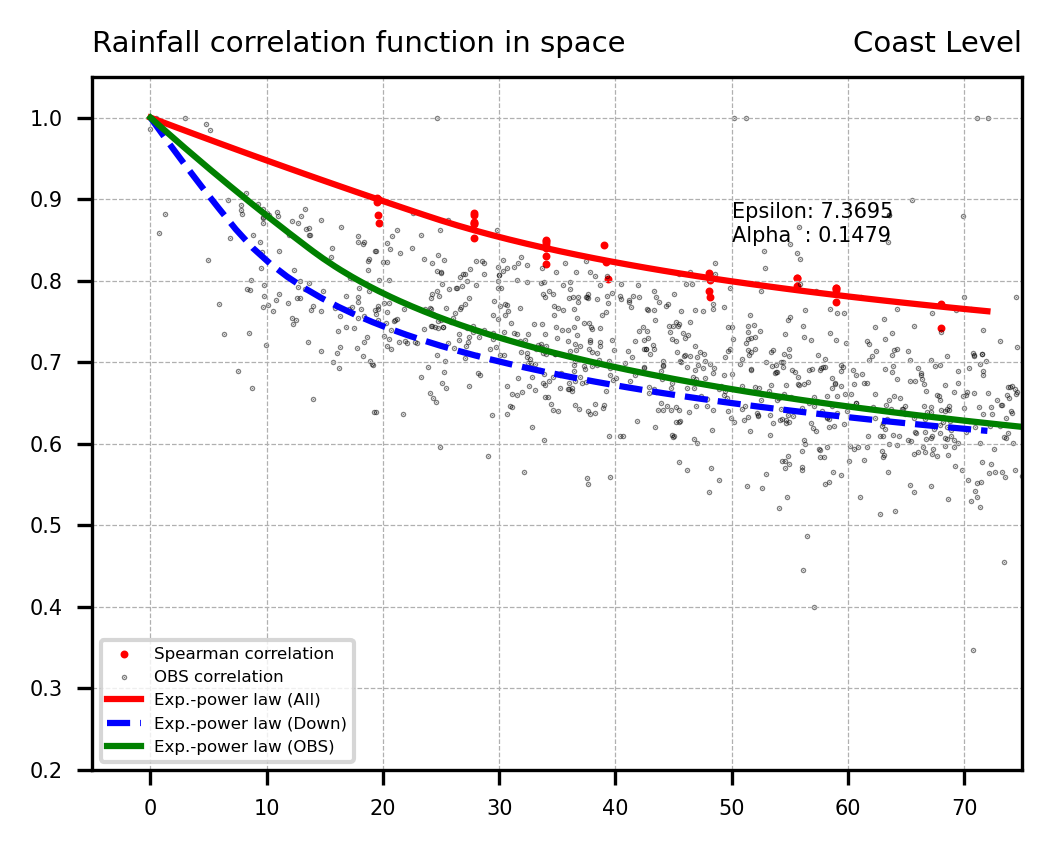

In [37]:
xx = np.linspace(0.0, min(100, 10*(np.round(np.max(vdist))//10+1.2)))

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0])
ax1.scatter(vdist, vcorr, s=0.8, c='r', label='Spearman correlation')
# ax1.scatter(vdist_ave, vcorr_ave, s=3, c='k', label='Mean-cluster correlation')
ax1.scatter(stations_corr['dist'].values, stations_corr['corr'].values, s=0.1, c='k', alpha=0.5, label='OBS correlation')

# ax1.plot(xx, corrL, '--c', label='integrated correlation')

ax1.annotate(f'Epsilon: {np.round(param1,4)}', xy=(50, 0.885), xytext=(50, 0.885),
                textcoords='data', fontsize=5, color='black',ha='left', va='center')
ax1.annotate(f'Alpha  : {np.round(param2,4)}', xy=(50, 0.855), xytext=(50, 0.855),
                textcoords='data', fontsize=5, color='black',ha='left', va='center')

if acf == 'mar':
    ax1.plot(xx, epl_fun(xx, FIT_eps, FIT_alp), '-r', label='Exp.-power law (All)')
    ax1.plot(xx, epl_fun(xx, param1, param2), '--b', label='Exp.-power law (Down)')
    ax1.plot(stations_corr['dist'].values, epl_fun(stations_corr['dist'].values, OBS_eps, OBS_alp), '-g', label='Exp.-power law (OBS)')
elif acf == 'str':
    ax1.plot(xx, str_exp_fun(xx, FIT_d0, FIT_mu0), '-r', label='Exp.-power law (All)')
    ax1.plot(xx, str_exp_fun(xx, param1, param2), '--b', label='Exp.-power law (Down)')
    ax1.plot(stations_corr['dist'].values, epl_fun(stations_corr['dist'].values, OBS_eps, OBS_alp), '-g', label='Exp.-power law (OBS)')

ax1.grid(linewidth=0.3, linestyle='--')
ax1.legend(fontsize = 4, loc=3)

ax1.xaxis.set_tick_params(labelsize=5)
ax1.yaxis.set_tick_params(labelsize=5)

ax1.set_xlim([-5, min(100, 10*(np.round(np.max(vdist))//10+1.5))])
ax1.set_ylim([0.2, 1.05])

ax1.set_title(f'{name}', fontsize=7, loc='right')
ax1.set_title('Rainfall correlation function in space', fontsize=7, loc='left')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [38]:
print('Downscaling pdf - yearly Weibull parameters')
NYd, CYd, WYd, gamYd, _ = down_wei(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], L1, L0, beta, (param1, param2), acf=acf)
# NYd, CYd, WYd, gamYd, _ = down_wei(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], L1, L0, beta, (OBS_eps, OBS_alp), acf=acf)

Downscaling pdf - yearly Weibull parameters
Gamma value: 0.9043708912218213


In [39]:
# function using weibull_param, beta, gamma
# NYd, CYd, WYd = down_wei_beta_alpha(IMERG_WEIBULL_YEAR[:,0], IMERG_WEIBULL_YEAR[:,1], IMERG_WEIBULL_YEAR[:,2], beta, 0.8722978009970423)

Export as: ../fig/down_v4/Veneto_IMERG_mar_Coast_Level_2001_2017_weibull_OVERLAP_1mm_8.png


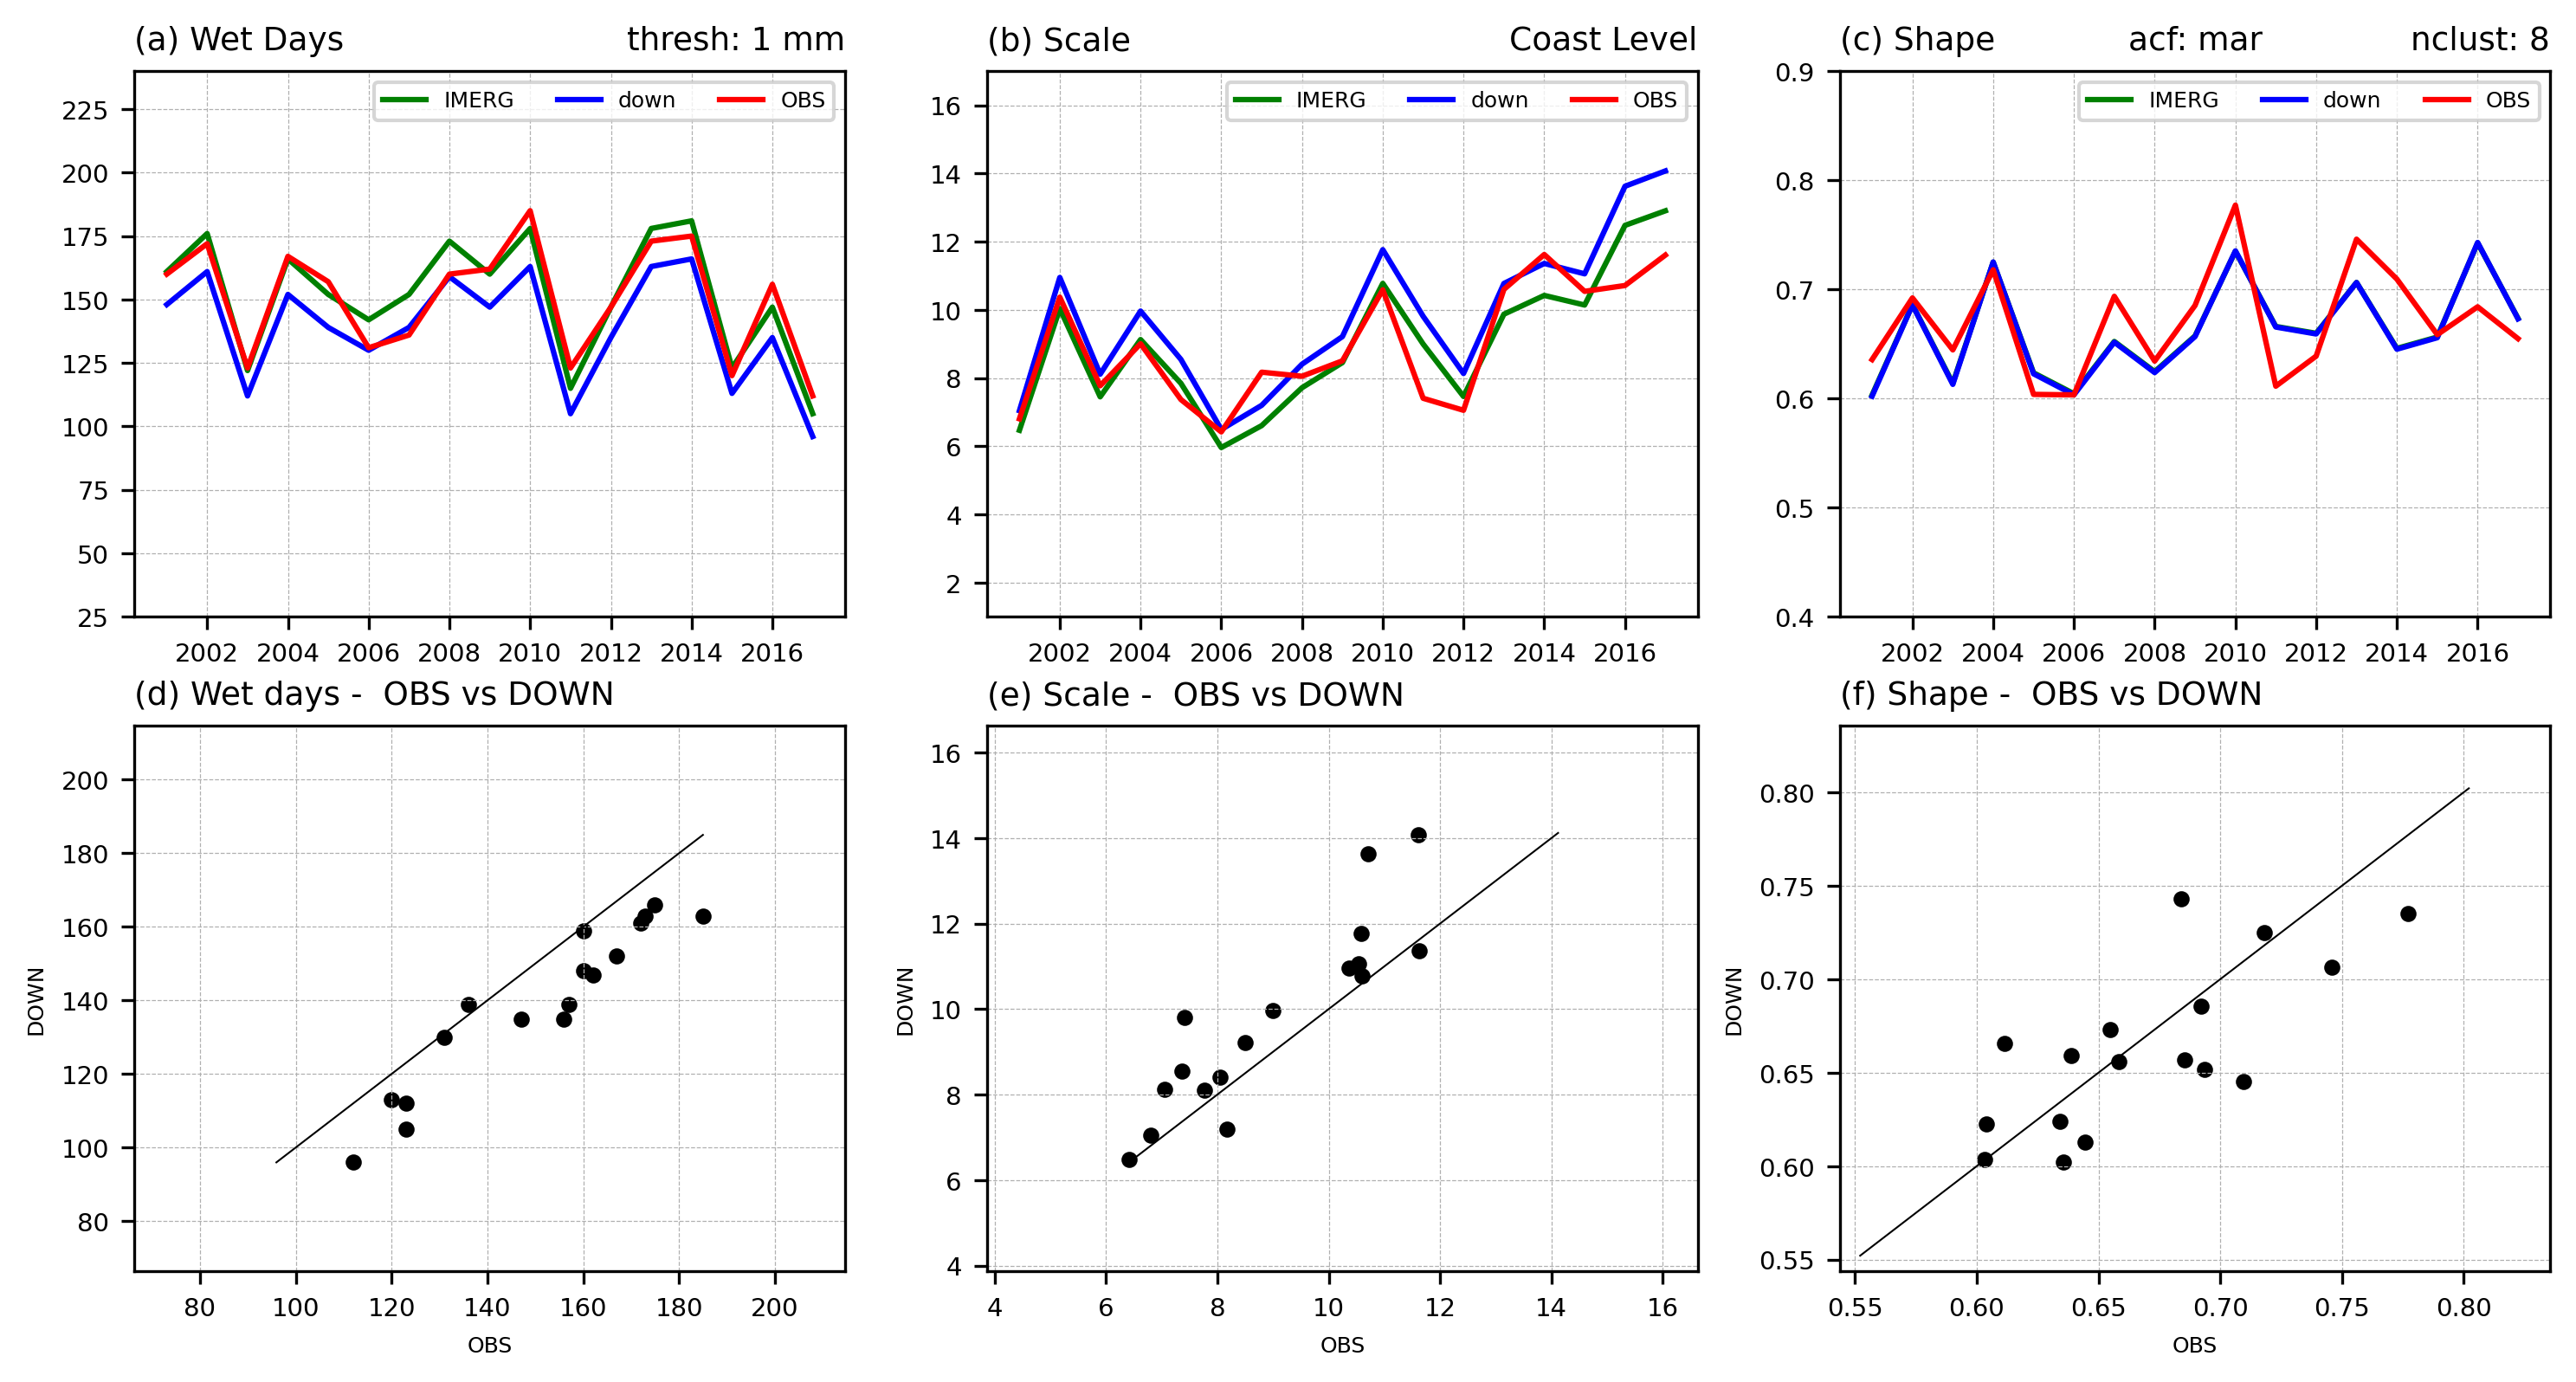

In [40]:
fig = plt.figure(figsize=(12,6),dpi=300)
gs = gridspec.GridSpec(2,3)

# ===========================================================================
ax1 = plt.subplot(gs[0,0])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,0], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], NYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,0], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(a) Wet Days', loc='left', fontsize=9)
ax1.set_title(f'thresh: {thresh} mm', loc='right', fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(25,240)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,1])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,1], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], CYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,1], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(b) Scale', loc='left', fontsize=9)
ax1.set_title(f'{name}',loc='right',fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(1,17)
ax1.grid(linewidth=0.3, linestyle='--')

ax1 = plt.subplot(gs[0,2])
ax1.plot(IMERG_WEIBULL_YEAR[:,3], IMERG_WEIBULL_YEAR[:,2], c='g', label='IMERG')
ax1.plot(IMERG_WEIBULL_YEAR[:,3], WYd, c='b', label='down')
ax1.plot(OBS_WEIBULL_YEAR[:,3], OBS_WEIBULL_YEAR[:,2], c='r', label='OBS')
ax1.legend(fontsize=6, ncol=3)
ax1.set_title('(c) Shape', loc='left', fontsize=9)
ax1.set_title(f'acf: {acf}',loc='center',fontsize=9)
ax1.set_title(f'nclust: {nclust}',loc='right',fontsize=9)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.set_ylim(0.4,0.9)
ax1.grid(linewidth=0.3, linestyle='--')

# ===========================================================================
ax1 = plt.subplot(gs[1,0])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,0]),np.max(NYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,0]),np.min(NYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,0]),np.max(NYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,0], NYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(d) Wet days -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,1])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,1]),np.max(CYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,1]),np.min(CYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,1]),np.max(CYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,1], CYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(e) Scale -  OBS vs DOWN', loc='left', fontsize=9)

ax1 = plt.subplot(gs[1,2])
x_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,2]),np.max(WYd)])]
y_limits = [np.min([np.min(OBS_WEIBULL_YEAR[:,2]),np.min(WYd)]),
        np.max([np.max(OBS_WEIBULL_YEAR[:,2]),np.max(WYd)])]
ax1.scatter(OBS_WEIBULL_YEAR[:,2], WYd, s=12, c='k', label='scatter')
ax1.plot(np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05),
        np.arange(x_limits[0]-0.05, x_limits[1]+0.05, 0.05), linewidth=0.5, c='k')
ax1.set_xlim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.set_ylim(x_limits[0]-(x_limits[1]-x_limits[0])/3,x_limits[1]+(x_limits[1]-x_limits[0])/3)
ax1.xaxis.set_tick_params(labelsize=7)
ax1.yaxis.set_tick_params(labelsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('DOWN', fontsize=6)
ax1.set_title('(f) Shape -  OBS vs DOWN', loc='left', fontsize=9)

# ===========================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

image_dir = f'../fig/down_v4/Veneto_IMERG_{acf}_{name.replace(' ','_')}_{yy_s}_{yy_e}_weibull_{fig_val}_{thresh}mm_{nclust}.png'
print(f'Export as: {image_dir}')
# plt.savefig(image_dir,transparent = False,bbox_inches ='tight',pad_inches = 0.01, facecolor=None)

## Daily Scatter Plot between OBS and IMERG

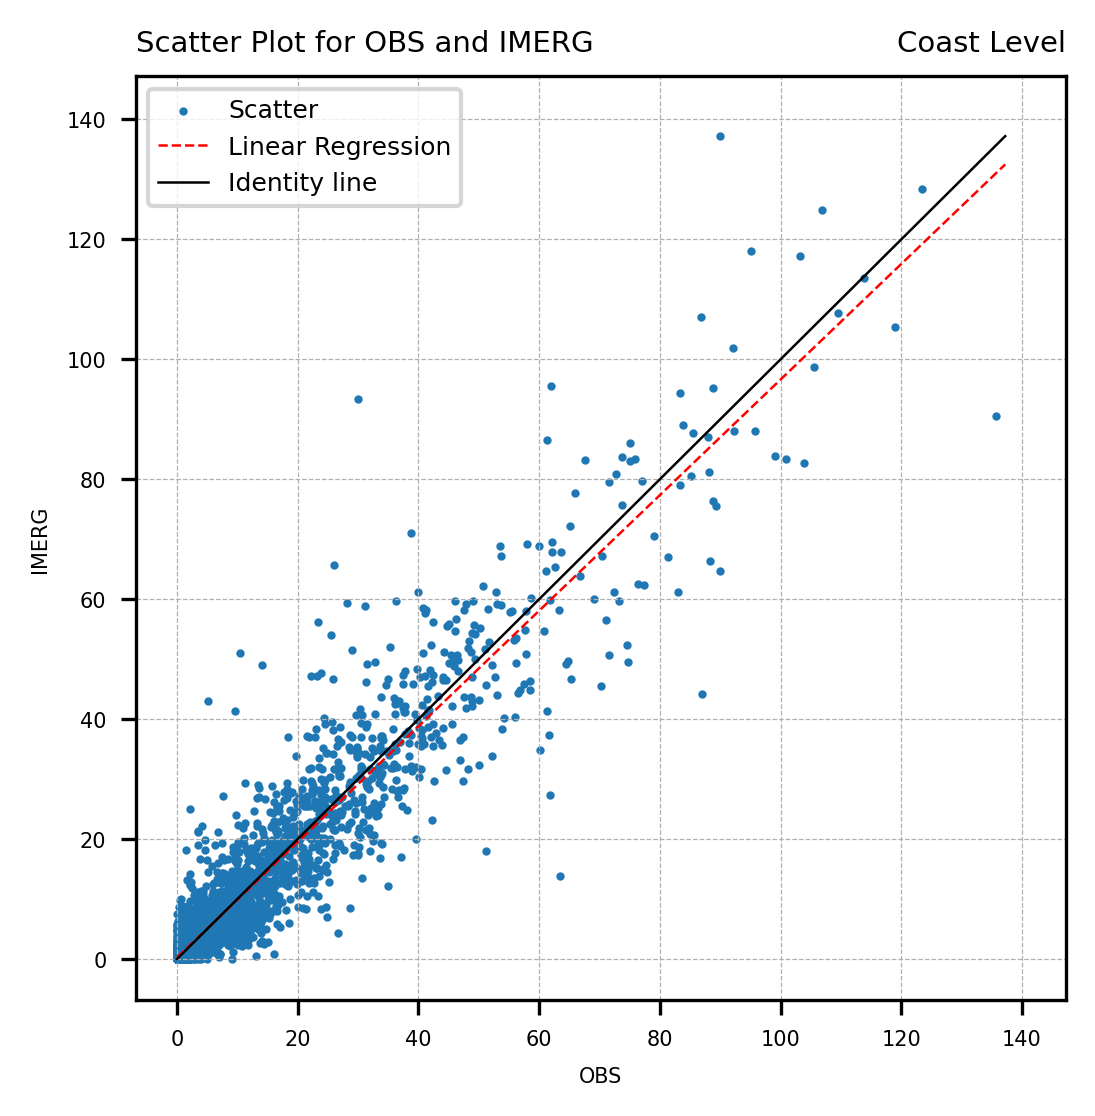

In [41]:
image_dir = f'../fig/down_v4/Veneto_IMERG_scatter_{name.replace(' ','_')}.png'
plot_scatter(IMERG_pixel_xr_01.data, IMERG_pixel_xr.data, name, image_dir, False)

## Manual Gamma

In [42]:
from scipy.integrate import dblquad

def myacf(x, y, parhat, acf):
    if acf == 'str':  # par d0, mu0
        return str_exp_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
    elif acf == 'mar':  # par:: epsilon, alpha
        return epl_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
    else:
        print('vrf ERROR: insert a valid auto correlation function')

fun_XY = lambda x, y: (L1 - x) * (L1 - y) * myacf(x, y, [param1, param2], acf)
fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * myacf(x, y, [param1, param2], acf)

In [43]:
L1_test = 25
L0_test = 0
int_XY, abserr   = dblquad(fun_XY,  0.0, L1_test,  lambda x: 0.0, lambda x: L1_test)
int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0_test, lambda x: 0.0, lambda x: L0_test)

if L0_test == 0:
    gam = ((4/L1_test**4)) * int_XY
else:
    gam = ((L0_test/L1_test)**4) * (int_XY / int_XY0) 

gam

0.6184986032053478

In [44]:
int_XY, int_XY0

(60400.25421927224, 0.0)